In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_ctcs.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")

compute_scaling (generic function with 1 method)

In [2]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/nominal_traj_unicycle_0324" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [34]:
dynamics = Unicycle()
ix = dynamics.ix
iu = dynamics.iu
alpha = 0.1
dynamics.β .= [2.0,2.0]
θ0 = 1.0

DLMI = LinearDLMI(alpha,ix,iu)
CTCS = QPD(10,1e-4,ix,iu)
# CTCS = HLsmooth(1e1,0.0,θ0,dynamics)
# CTCS = QPDDet(1e-4,ix,iu)

QPD(10.0, 0.0001, 1, 3, 2, 9, 6)

In [35]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

In [36]:
Qnom = zeros(ix,ix,N+1)
Ynom = zeros(iu,ix,N+1)
Znom = zeros(ix,ix,N+1);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])

3×3 Matrix{Float64}:
 0.08  0.0   0.0
 0.0   0.08  0.0
 0.0   0.0   0.06

In [37]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)
scaler.s_ctcs = 1e3

1000.0

In [38]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 2 methods)

In [55]:
max_iter = 1;
w_funl = 1.0;
w_vc = 1e2;
w_tr::Float64 = 1e5
tol_vc = 1e-8;
tol_tr = 1e-9;
tol_dyn = 1e-1;
verbosity = true;

In [56]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,
    verbosity,
    flag_type="Lsmooth",
    funl_ctcs=CTCS
    );

Lsmooth funnel and CTCS is considered after first iteration


In [57]:
run(fs,Qnom,Ynom,Znom,Qini,Qf,xnom,unom,dtnom,"Mosek",θ0)

+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |2.00        |-1.000    |1.995      |-1.000     |-1.000    |-Inf     | -0.9     |-7.6e+00   |


In [58]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Qprop,Yprop,Zprop = fs.solution.Qprop,fs.solution.Yprop,fs.solution.Zprop
print(fs.solution.ctcs_fwd)

[2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7 2.5000000000000015e-7]

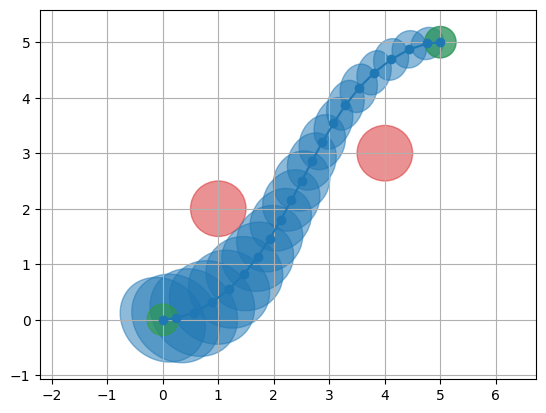

In [59]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(fs.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(fs.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(fs.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = xnom[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([xnom[:,1],xnom[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(xnom[1,:],xnom[2,:],"o-",color="tab:blue")
# ax.plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],"-",color="tab:blue")
ax.grid(true)
ax[:axis]("equal")
gcf()

## Check eigenvalue of Q

In [60]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(fs.solution.Q,3))
for i in 1:size(fs.solution.Q,3)
    eigvals = eigen(fs.solution.Q[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

In [61]:
idx_min = argmin(min_lam_qprop)
println("prop ",minimum(min_lam_qprop))
println("nom ",minimum(min_lam_q))

prop -0.014800456634006297
nom 1.0052730657794662e-5


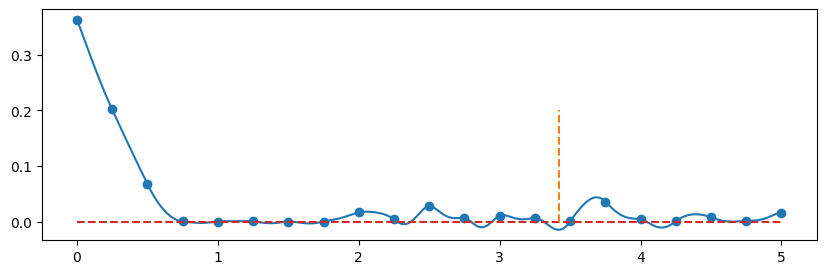

In [62]:
plt.figure(figsize=(10,3))
plt.plot(tnom,min_lam_q,"o",color="tab:blue")
plt.plot(tprop,min_lam_qprop,"-",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
plt.vlines(tprop[idx_min],ymin=0,ymax=0.2,linestyle="--",color="tab:orange")
# plt.xlim([tnom[19],tnom[20]])
# plt.ylim([-1e-3,1e-3])
gcf()

## Check eigenvalue of Block DLMI

In [47]:
θ = θ0[1]
fs.dynamics.β
iψ = fs.dynamics.iψ
iμ = fs.dynamics.iμ
using Interpolations
fit_b = LinearInterpolation(tnom, fs.solution.b,extrapolation_bc=Flat());
bprop = fit_b(tprop);

In [48]:
function get_H(fs,Qprop,Yprop,Zprop,bprop,θ)
    # N11 =  I(fs.dynamics.iμ) .* (θ ./ ( fs.dynamics.β .* fs.dynamics.β))
    N11 = diagm(θ ./ (fs.dynamics.β .* fs.dynamics.β))
    N22 =  bprop .* θ .* I(fs.dynamics.iψ)
    LMI11 = -Zprop
    LMI21 = N22 * fs.dynamics.G'
    LMI22 = -N22
    LMI31 = fs.dynamics.Cμ * Qprop + fs.dynamics.Dμu * Yprop
    LMI32 = zeros(fs.dynamics.iμ,fs.dynamics.iψ)
    LMI33 = -N11
    H = [LMI11 LMI21' LMI31';
        LMI21 LMI22 LMI32';
        LMI31 LMI32 LMI33]
    return H

    # M = 1e-5
    # N = 1e4
    # iH = size(H,1)
    # epsilon = 0.0 .* Matrix{Float64}(I, iH, iH)
    # g = log(M) - log(N*det(-H-epsilon) + M)

    # return max(0,g)
 end

get_H (generic function with 1 method)

In [49]:
Hprop = zeros(ix+iψ+iμ,ix+iψ+iμ,length(tprop))
H = zeros(ix+iψ+iμ,ix+iψ+iμ,length(tnom))
for i in 1:length(tprop)
    Hprop[:,:,i] .= get_H(fs,Qprop[:,:,i],Yprop[:,:,i],Zprop[:,:,i],bprop[i],θ)
end
for i in 1:length(tnom)
    H[:,:,i] .= get_H(fs,fs.solution.Q[:,:,i],fs.solution.Y[:,:,i],
        fs.solution.Z[:,:,i],fs.solution.b[i],θ)
end

In [50]:
max_lam_Hprop = zeros(size(Hprop,3))
for i in 1:size(Qprop,3)
    eig_vals = eigen(Hprop[:,:,i]).values
    if i == 1
        println(eig_vals)
    end
    max_lam_Hprop[i] = eig_vals[end]
end
max_lam_H = zeros(size(H,3))
for i in 1:size(H,3)
    eig_vals = eigen(H[:,:,i]).values
    if i == 1
        println(eig_vals)
    end
    max_lam_H[i] = eig_vals[end]
end
val_ctcs_prop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    val_ctcs_prop[i] = forward(CTCS,vec(Qprop[:,:,i]),vec(Yprop[:,:,i]),vec(Zprop[:,:,i]),bprop[i])
end
val_ctcs = zeros(size(H,3))
for i in 1:size(H,3)
    val_ctcs[i] = forward(CTCS,vec(fs.solution.Q[:,:,i]),
        vec(fs.solution.Y[:,:,i]),vec(fs.solution.Z[:,:,i]),fs.solution.b[i])
end

[-1.1533785119808422, -1.0537341582835364, -0.7760784127678326, -0.3063669575044847, -3.026103812449349e-8, -1.65476231886541e-8, -9.851292093258652e-9]
[-1.1533785119808422, -1.0537341582835364, -0.7760784127678326, -0.3063669575044847, -3.026103812449349e-8, -1.65476231886541e-8, -9.851292093258652e-9]


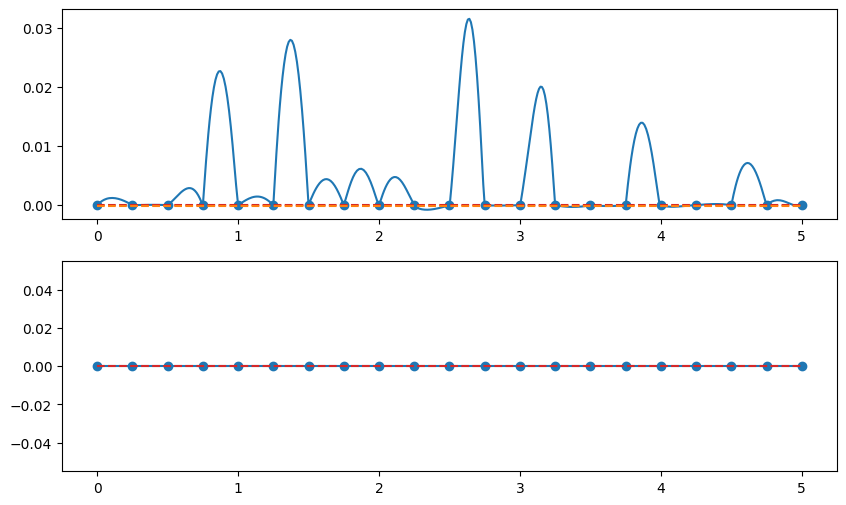

In [51]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(tprop,max_lam_Hprop,"-",color="tab:blue")
plt.plot(tnom,max_lam_H,"o",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
plt.plot(tprop,-fs.funl_ctcs.epsilon .+ tprop*0,"--",color="tab:orange")
# plt.ylim(0,1e-6)
plt.subplot(212)
plt.plot(tprop,val_ctcs_prop,"-",color="tab:blue")
plt.plot(tnom,val_ctcs,"o",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
gcf()

In [52]:
function project_onto_input(Q,Y) 
    R = []
    for i in 1:size(Q,3)
        K = Y[:,:,i] * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [53]:
input_proj_funl_prop = project_onto_input(Qprop,Yprop)
input_proj_funl_nom = project_onto_input(fs.solution.Q,fs.solution.Y)

2-element Vector{Any}:
 Any[0.343230005636602, 0.3377406562189801, 0.33637001663986993, 0.30824400476598934, 0.30608697451329386, 0.3177039858409608, 0.32323963945773176, 0.2679831877734173, 0.26717700338518885, 0.25110847839796885  …  0.2907494401539899, 0.28915342080041645, 0.28521226051531673, 0.2357838042790782, 0.29183058638721915, 0.25938312883347253, 0.2278146200734474, 0.2864340794288728, 0.23573073564135066, 0.14187363221140467]
 Any[1.4157123967425367, 1.010014952493721, 1.1890672354736465, 0.5310317059806965, 0.6927956464658044, 0.7157990975179135, 0.9914715595227617, 0.6743814340421354, 1.0878192953948231, 1.145773423311493  …  1.7446489764590731, 1.8636545740147534, 1.4935954370969746, 0.2346471443947032, 1.547232933317435, 1.0743626500894208, 0.7720822036665475, 1.136785075656224, 0.9296508972434159, 1.4263425013528757]

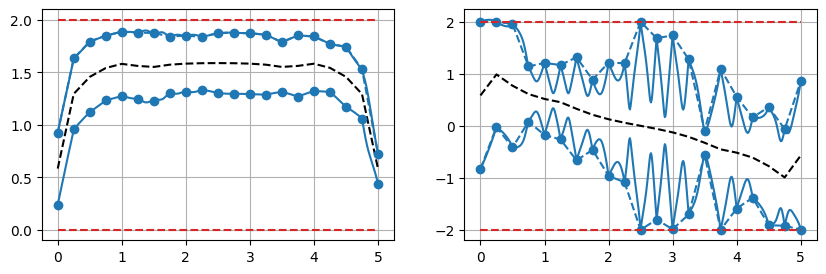

In [54]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(tnom,unom[1,:],"--",color="black")
plt.plot(tnom,unom[1,:]+input_proj_funl_nom[1],"o--",color="tab:blue")
plt.plot(tnom,unom[1,:]-input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tprop,uprop[1,:]+input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tprop,uprop[1,:]-input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ vmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ vmin,"--",color="tab:red")
# plt.ylim([-0.1,2.1])
plt.grid(true)
plt.subplot(122)
plt.plot(tnom,unom[2,:],"--",color="black")
plt.plot(tnom,unom[2,:]+input_proj_funl_nom[2],"o--",color="tab:blue")
plt.plot(tnom,unom[2,:]-input_proj_funl_nom[2],"o--",color="tab:blue")
plt.plot(tprop,uprop[2,:]+input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tprop,uprop[2,:]-input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ wmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ wmin,"--",color="tab:red")
# plt.ylim([-2.5,2.5])
plt.grid(true)
gcf()

In [ ]:
# my_dict = Dict("x" => xnom, "u" => unom, "t" => tnom,
#      "Q" => fs.solution.Q, "Y" => fs.solution.Y, "Z" => fs.solution.Z)
# using JLD2, FileIO

# @save "./data/xuQYZ_unicycle_0328" my_dict